In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from scipy.stats import pearsonr

In [2]:
save_dir = "results/word_freq_vs_(P)LL"
os.makedirs(save_dir, exist_ok=True)

In [3]:
contexts = ["I opened a dictionary and randomly picked a word. It was", "I opened the dictionary and picked the word", "My word is", ""]

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [5]:
def get_plot_df(MODEL, DATASET, MASKING, context):
    # Load likelihood scores
    if context :
        #print(f"Using context #{context}#!")
        likelihoods = pd.read_csv(f'results/unigram_likelihoods/{MODEL}/{DATASET}{MASKING}_context={"+".join(context.split())}.csv')
    else:
        likelihoods = pd.read_csv(f'results/unigram_likelihoods/{MODEL}/{DATASET}{MASKING}.csv')
    likelihoods = likelihoods.rename(columns={
        "word" : "Word"
    })
    
    # Load word frequency information
    freqs = pd.read_csv(f'results/unigram_frequencies/{DATASET}_unigram_frequencies.txt', sep='\t')
    
    # frequencies are already log scored
    freqs = freqs.rename(columns={
        "Unigram_freq" : "log freq"
    })

    # Merge
    plot_df = freqs.merge(likelihoods, how="inner", on='Word')
    
    plot_df.to_csv(f'{save_dir}/{DATASET}_{MODEL}{MASKING}_aligned.csv', index=False)

    # Exclude rows with 1 frequency added via smoothing
    plot_df = plot_df.loc[plot_df["log freq"] != 0]
    
    return plot_df

In [6]:
def get_plot_df_brown(MODEL, DATASET, MASKING, context):
    likelihood_frames = []
    for chunk_ind in range(10):
        # Load likelihood scores
        if context :
            #print(f"Using context #{context}#!")
            likelihoods = pd.read_csv(f'results/unigram_likelihoods/{MODEL}/{DATASET}{MASKING}_context={"+".join(context.split())}_chunk={chunk_ind}.csv')
        else:
            likelihoods = pd.read_csv(f'results/unigram_likelihoods/{MODEL}/{DATASET}{MASKING}_chunk={chunk_ind}.csv')
        likelihood_frames.append(likelihoods)
    likelihoods = pd.concat(likelihood_frames)
    likelihoods = likelihoods.rename(columns={
        "word" : "Word"
    })
    
    freq_frames = []
    for chunk_ind in range(10):
        # Load word frequency information
        freqs = pd.read_csv(f'results/unigram_frequencies/{DATASET}_unigram_frequencies_chunk_{chunk_ind}.txt', sep='\t')
        freq_frames.append(freqs)
    freqs = pd.concat(freq_frames)
    
     # frequencies are already log scored
    freqs = freqs.rename(columns={
        "Unigram_freq" : "log freq"
    })

    # Merge
    plot_df = freqs.merge(likelihoods, how="inner", on='Word')
    
    plot_df.to_csv(f'{save_dir}/{DATASET}_{MODEL}{MASKING}_aligned.csv', index=False)
    
    # Exclude rows with 1 frequency added via smoothing
    plot_df = plot_df.loc[plot_df["log freq"] != 0]
    
    return plot_df

In [7]:
def assign_significance(pval):
    if pval < 0.001:
        sig = "***"
    elif pval < 0.01:
        sig = "**"
    elif pval < 0.05:
        sig = "*"
    else:
        sig = "n.s."
    return sig

In [8]:
RENAME_DICT_MODELS = {
    "gpt2-medium" : "GPT2-medium",
    "gpt2-xl" : "GPT2-xl",
    "bert-base-cased" : "BERT (base)",
    "bert-large-cased" : "BERT (large)",
    "roberta-base" : "RoBERTa (base)"
}

RENAME_DICT_METRICS = {
    "_OriginalPLL" : "| PLL-original",
    "_AdjustedPLL_l2r" : "| PLL-word-l2r",
    "_AdjustedPLL_mlm" : "| PLL-whole-word",
    "_AdjustedPLL_global_l2r" : "| PLL-sentence-l2r",
    "" : ""
}

def rename(x):
    if x in RENAME_DICT_MODELS:
        return RENAME_DICT_MODELS[x]
    else:
        return RENAME_DICT_METRICS[x]

# Individual plots

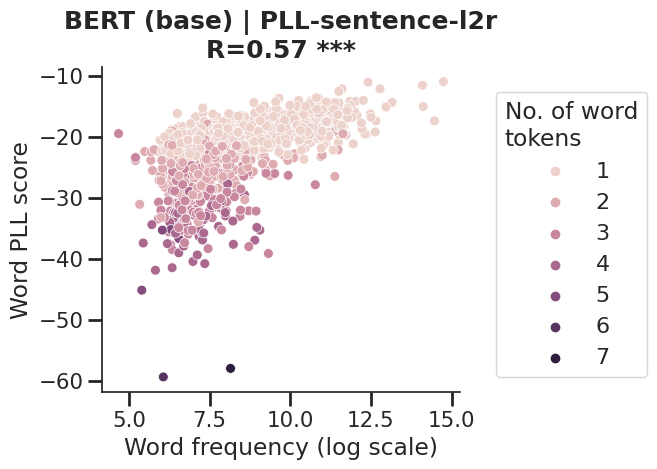

In [9]:
def freq_vs_PLL(BERT_VERSION, DATASET="EventsAdapt", context="My word is",
                         MASKING="_AdjustedPLL_global_l2r"):

    fig, ax = plt.subplots(figsize=(5, 5))

    if DATASET == "Brown":
        plot_df = get_plot_df_brown(BERT_VERSION, DATASET, MASKING, context)
    else:
        plot_df = get_plot_df(BERT_VERSION, DATASET, MASKING, context)
    nr_classes = len(plot_df["nr. of tokens"].unique())

    if DATASET == "Brown":
        plot_df = get_plot_df_brown(BERT_VERSION, DATASET, MASKING, context)
    else:
        plot_df = get_plot_df(BERT_VERSION, DATASET, MASKING, context)
    r, pval = pearsonr(plot_df["log freq"], plot_df["word score"])


    # call regplot on each axes
    sns.scatterplot(data=plot_df, x="log freq", y="word score",
               palette=sns.cubehelix_palette(nr_classes),
               hue="nr. of tokens", 
               edgecolor="w",
               linewidth=0.5,
               s=50).set_title(f'{rename(BERT_VERSION)} {rename(MASKING)}\nR={round(r,2)} {assign_significance(pval)}',
                          fontdict={"fontweight":"bold", "fontsize":18}, pad=7)
    ax.set(xlabel="Word frequency (log scale)", ylabel="Word PLL score")
    ax.tick_params(axis='both', which='major', length=10, width=2)
    ax.tick_params(axis='both', which='minor', length=10, width=2)
    ax.get_legend().remove()

    # Put a legend to the right of the current axis
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=False,
               ncol=1, title='No. of word\ntokens', fontsize=16)
#     if context == "":
#         fig.suptitle(f"No context", fontweight="bold", fontstyle='italic')
#     else:
#         fig.suptitle(f"Context: {context}", fontweight="bold", fontstyle='italic')
        
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{DATASET}_{BERT_VERSION}{MASKING}context={'+'.join(context.split())}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_{BERT_VERSION}{MASKING}context={'+'.join(context.split())}.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_{BERT_VERSION}{MASKING}context={'+'.join(context.split())}.svg", dpi=300, bbox_inches='tight')
    plt.show()
    
freq_vs_PLL(BERT_VERSION='bert-base-cased')
    
    

# Subplots

In [9]:
def freq_vs_PLL_subplots(GPT_VERSION, BERT_VERSION, DATASET, context, sharey=False):
    
    MODEL_MASKING = [(GPT_VERSION, "")]
    berts = [BERT_VERSION] * 3
    maskings = ["_OriginalPLL", "_AdjustedPLL_l2r", "_AdjustedPLL_mlm"]
    MODEL_MASKING.extend(list(zip(berts,maskings)))
    
    fig, axes = plt.subplots(ncols=len(MODEL_MASKING), sharey=sharey, figsize=(18, 5))
#     if context != "":
#         fig.suptitle(f'{DATASET} | Word frequency vs. word (P)LL\nContext: [CLS] {context} "[WORD]". [SEP]')
#     else:
#         fig.suptitle(f'{DATASET} | Word frequency vs. word (P)LL\nContext: [CLS] [WORD] [SEP]')
    
    max_nr_classes = 0
    for ind, (MODEL, MASKING) in enumerate(MODEL_MASKING):
        if DATASET == "Brown":
            plot_df = get_plot_df_brown(MODEL, DATASET, MASKING, context)
        else:
            plot_df = get_plot_df(MODEL, DATASET, MASKING, context)
        nr_classes = len(plot_df["nr. of tokens"].unique())
        if nr_classes > max_nr_classes:
            max_nr_classes = nr_classes
    
    for ind, (MODEL, MASKING) in enumerate(MODEL_MASKING):
        if DATASET == "Brown":
            plot_df = get_plot_df_brown(MODEL, DATASET, MASKING, context)
        else:
            plot_df = get_plot_df(MODEL, DATASET, MASKING, context)
        r, pval = pearsonr(plot_df["log freq"], plot_df["word score"])
        
#         if not "gpt" in MODEL:
#             axes[ind].set_facecolor("whitesmoke")
        
        # call regplot on each axes
        sns.scatterplot(data=plot_df, x="log freq", y="word score",
                   palette=sns.cubehelix_palette(max_nr_classes),
                   hue="nr. of tokens", 
                   edgecolor="w",
                   linewidth=0.5,
                   s=50,
                   ax=axes[ind]).set_title(f'{rename(MODEL)} {rename(MASKING)}\nR={round(r,2)} {assign_significance(pval)}',
                              fontdict={"fontweight":"bold", "fontsize":18}, pad=7)
        if "gpt" in MODEL:
            axes[ind].set(xlabel="Word frequency (log scale)", ylabel="Word LL score")
        else:
            axes[ind].set(xlabel="Word frequency (log scale)", ylabel="Word PLL score")
        axes[ind].tick_params(axis='both', which='major', length=10, width=2)
        axes[ind].tick_params(axis='both', which='minor', length=10, width=2)
        axes[ind].get_legend().remove()
        
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center',bbox_to_anchor=(0.5, 0),
          fancybox=True, shadow=False, ncol=max_nr_classes, title='No. of word tokens', fontsize=16)
    if context == "":
        fig.suptitle(f"No context", fontweight="bold", fontstyle='italic')
    else:
        fig.suptitle(f"Context: {context}", fontweight="bold", fontstyle='italic')
        
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{DATASET}_context={'+'.join(context.split())}_subplots_sharey={sharey}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_context={'+'.join(context.split())}_subplots_sharey={sharey}.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_context={'+'.join(context.split())}_subplots_sharey={sharey}.svg", dpi=300, bbox_inches='tight')
    plt.show()

# EventsAdapt | All joined

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


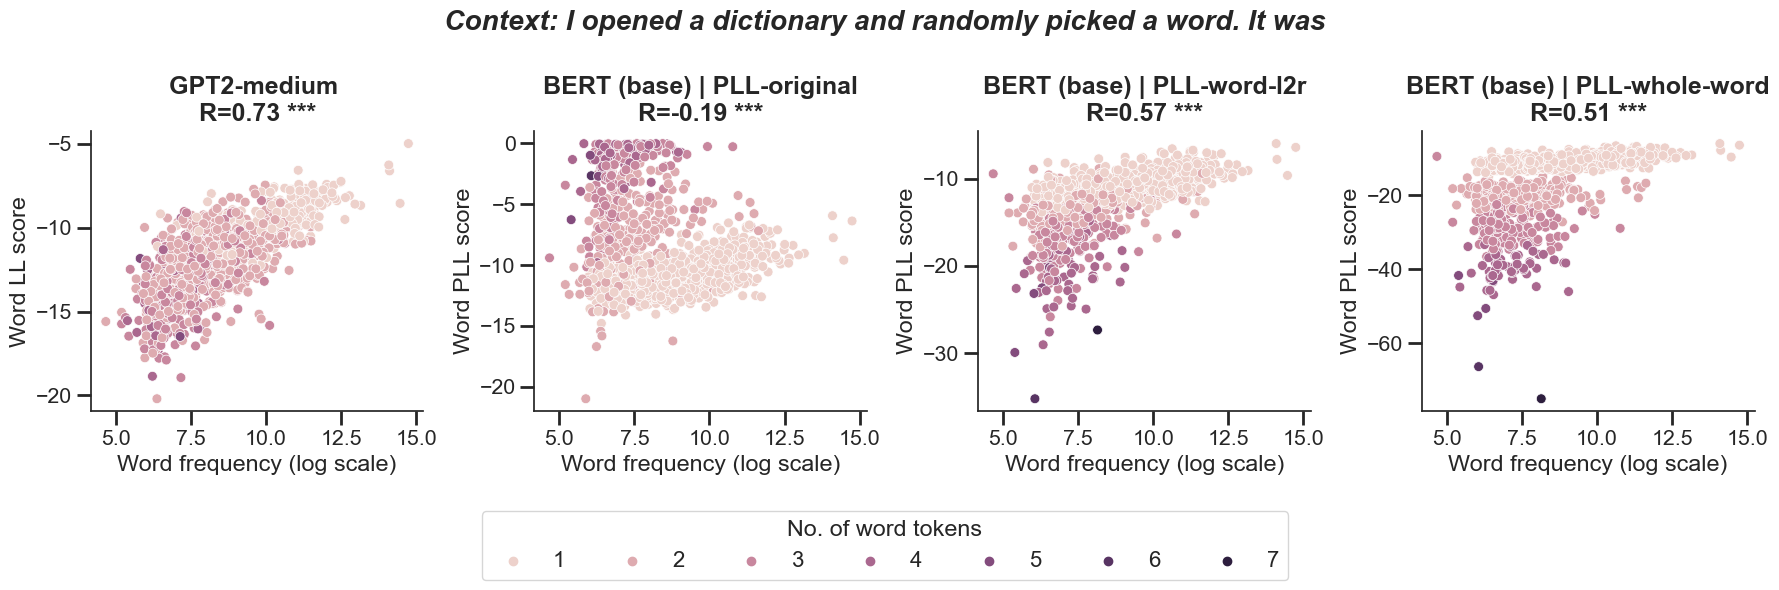

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


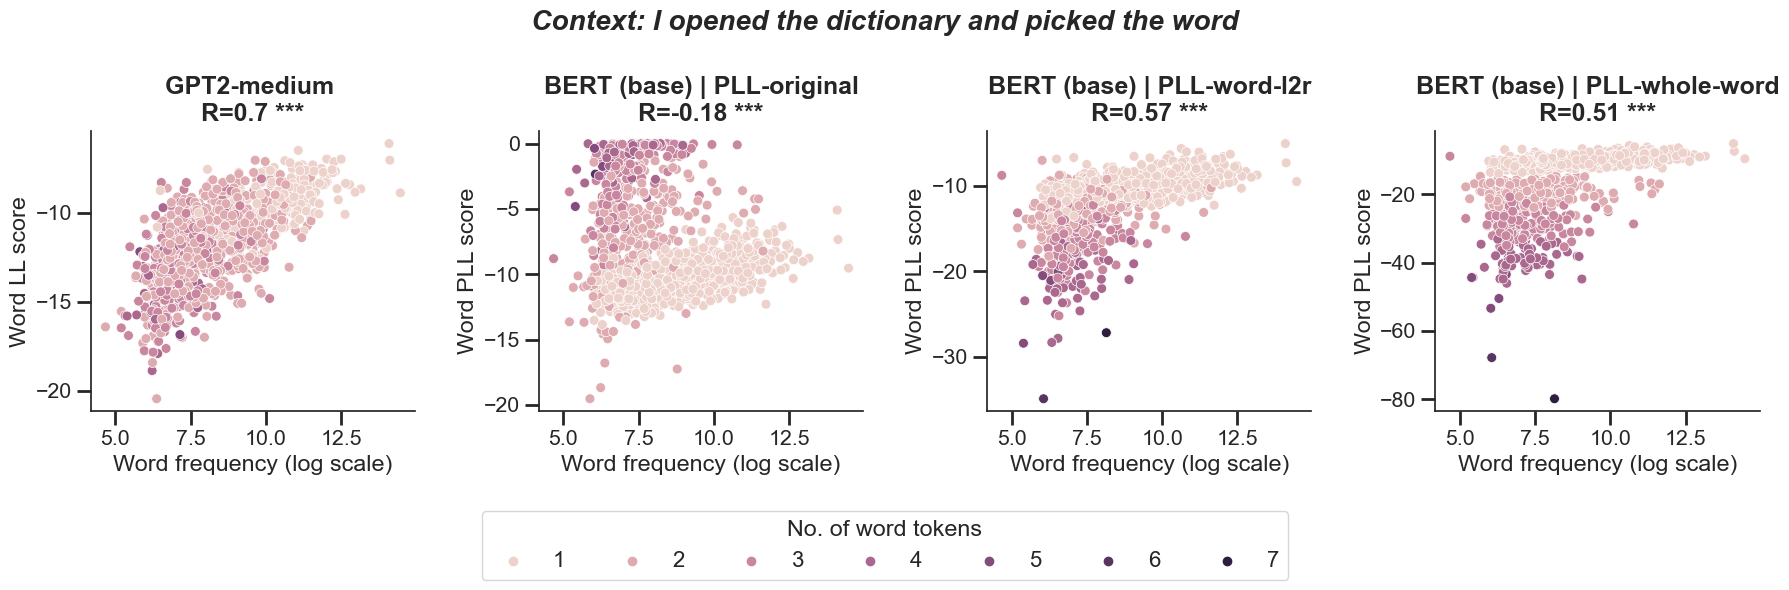

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


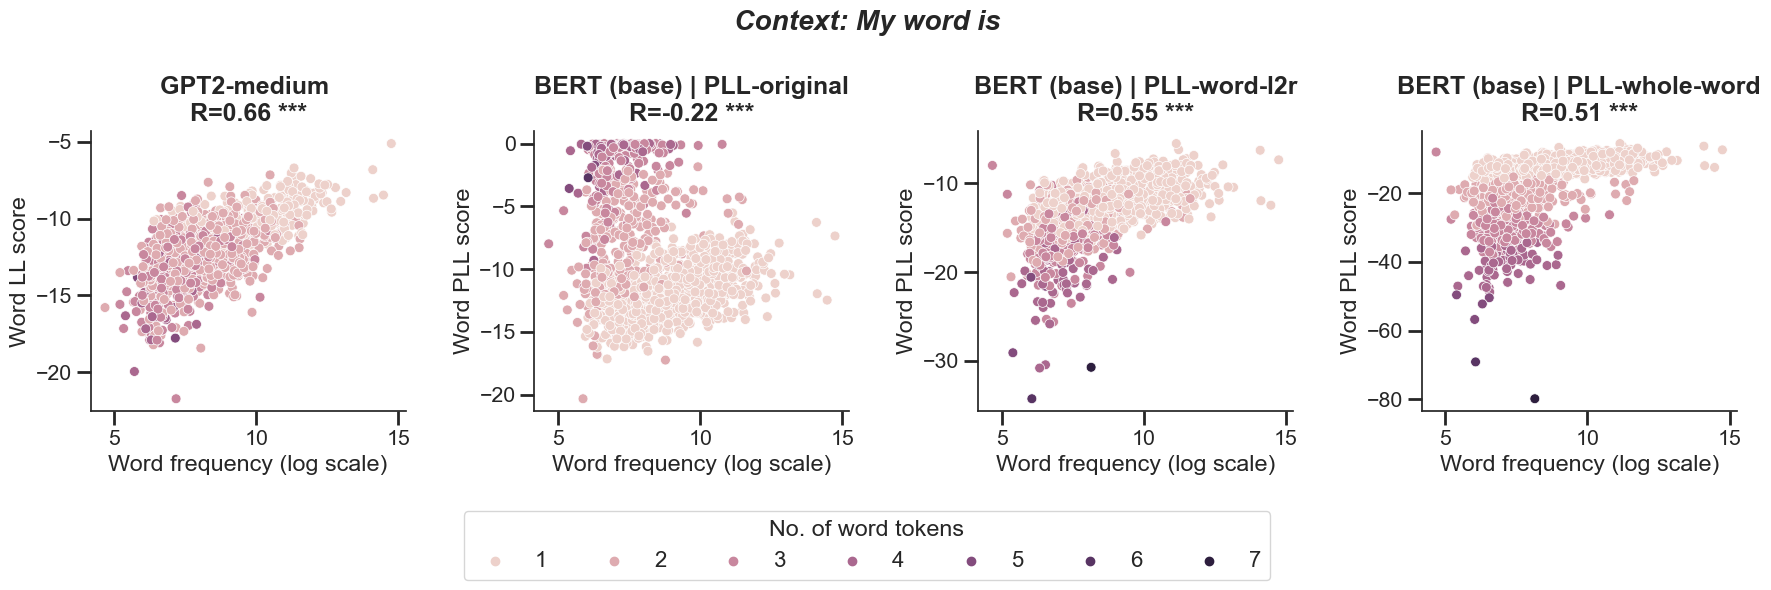

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


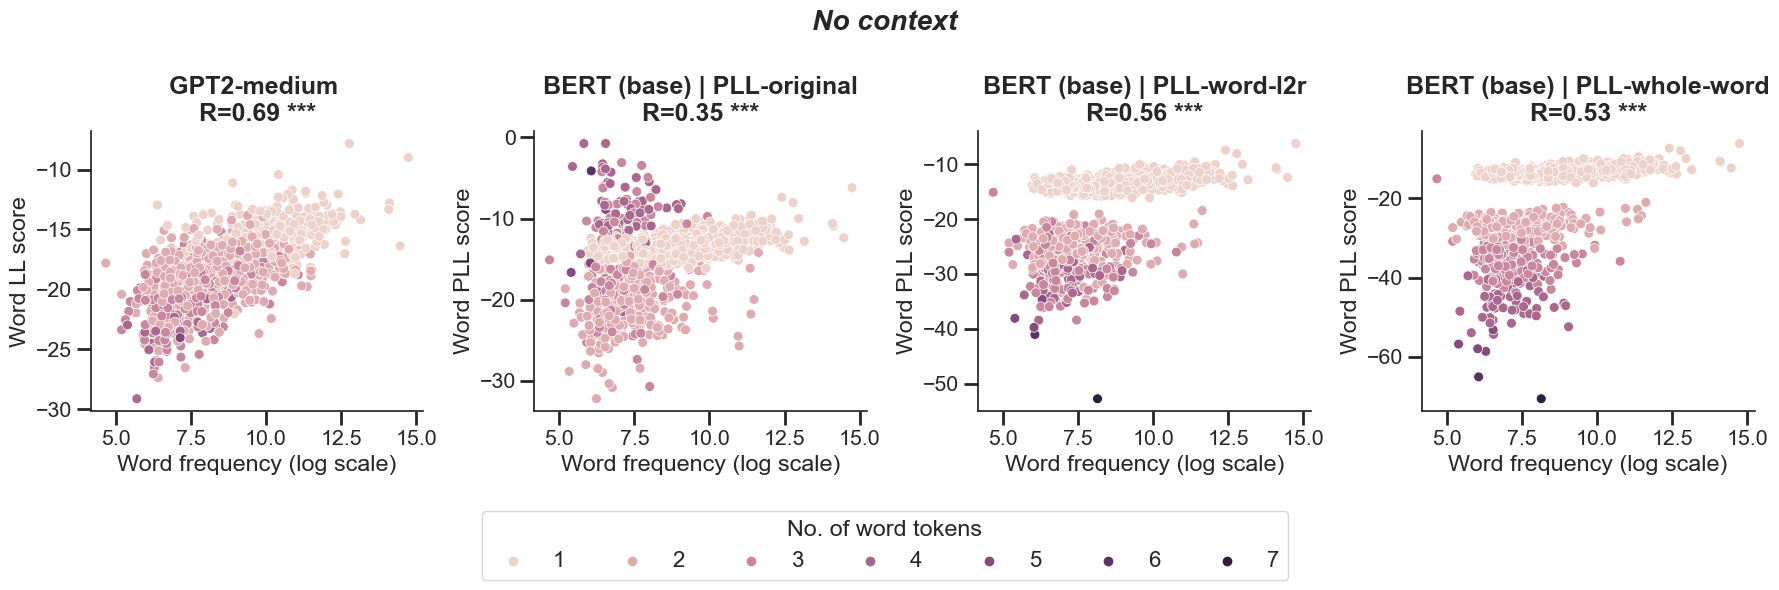

In [10]:
for context in contexts:
    for DATASET in ["EventsAdapt"]:
        freq_vs_PLL_subplots(GPT_VERSION="gpt2-medium", BERT_VERSION="bert-base-cased", DATASET="EventsAdapt",
                         context=context)

# Other datasets

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


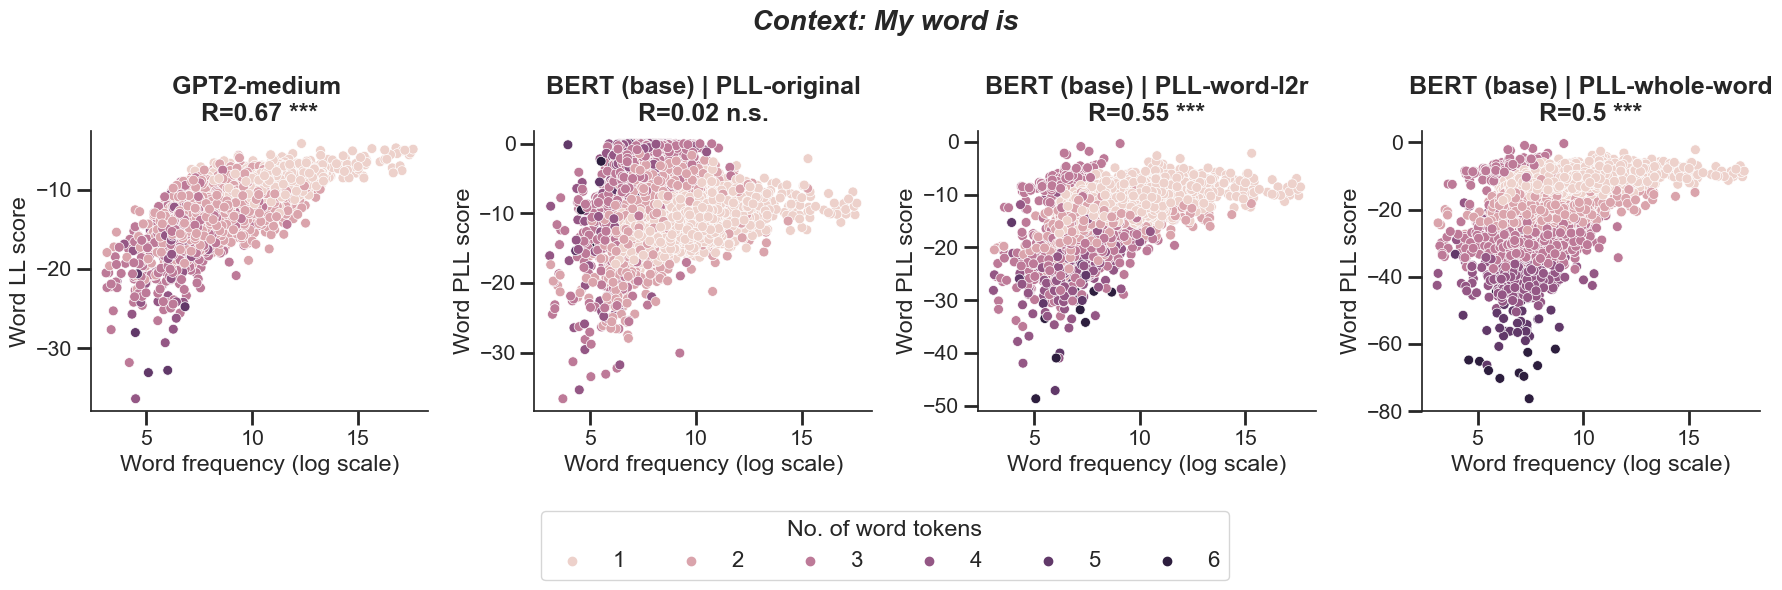

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


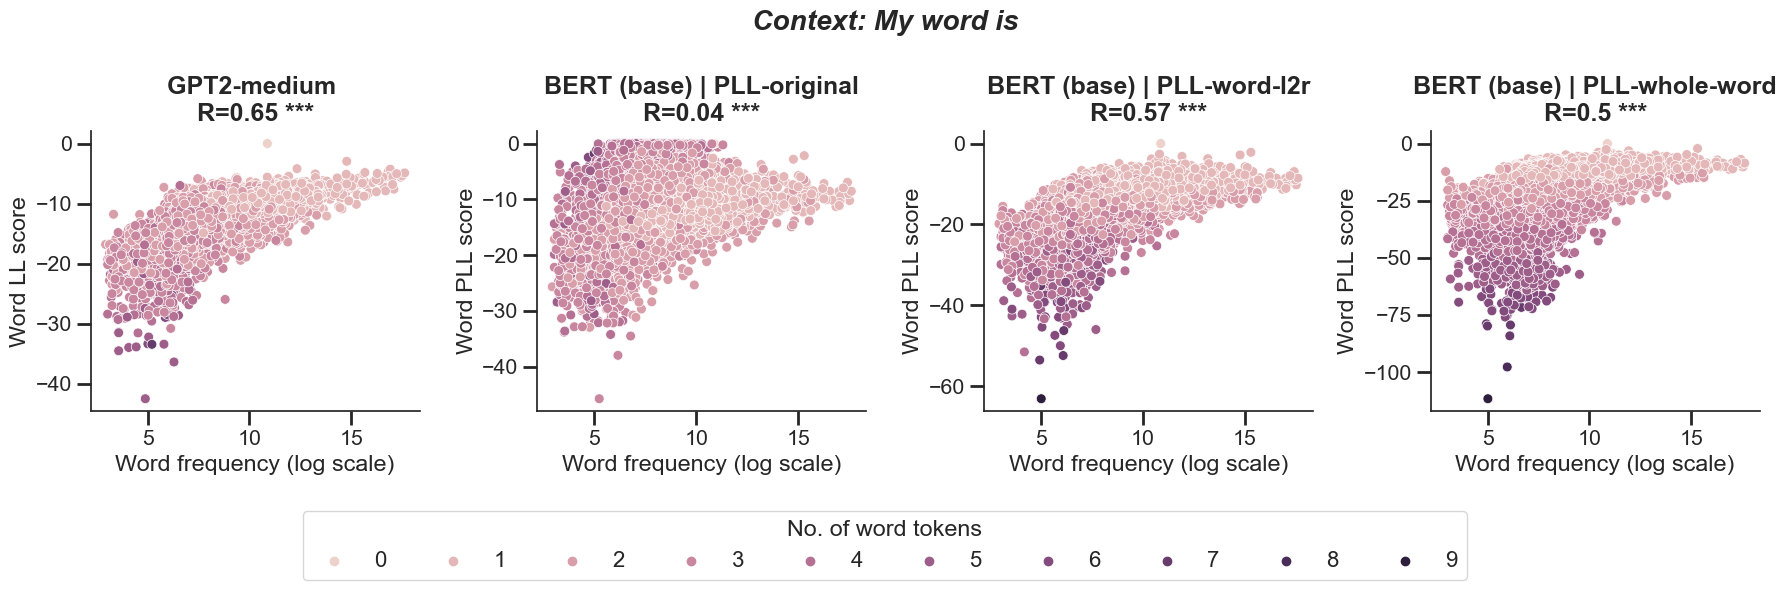

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


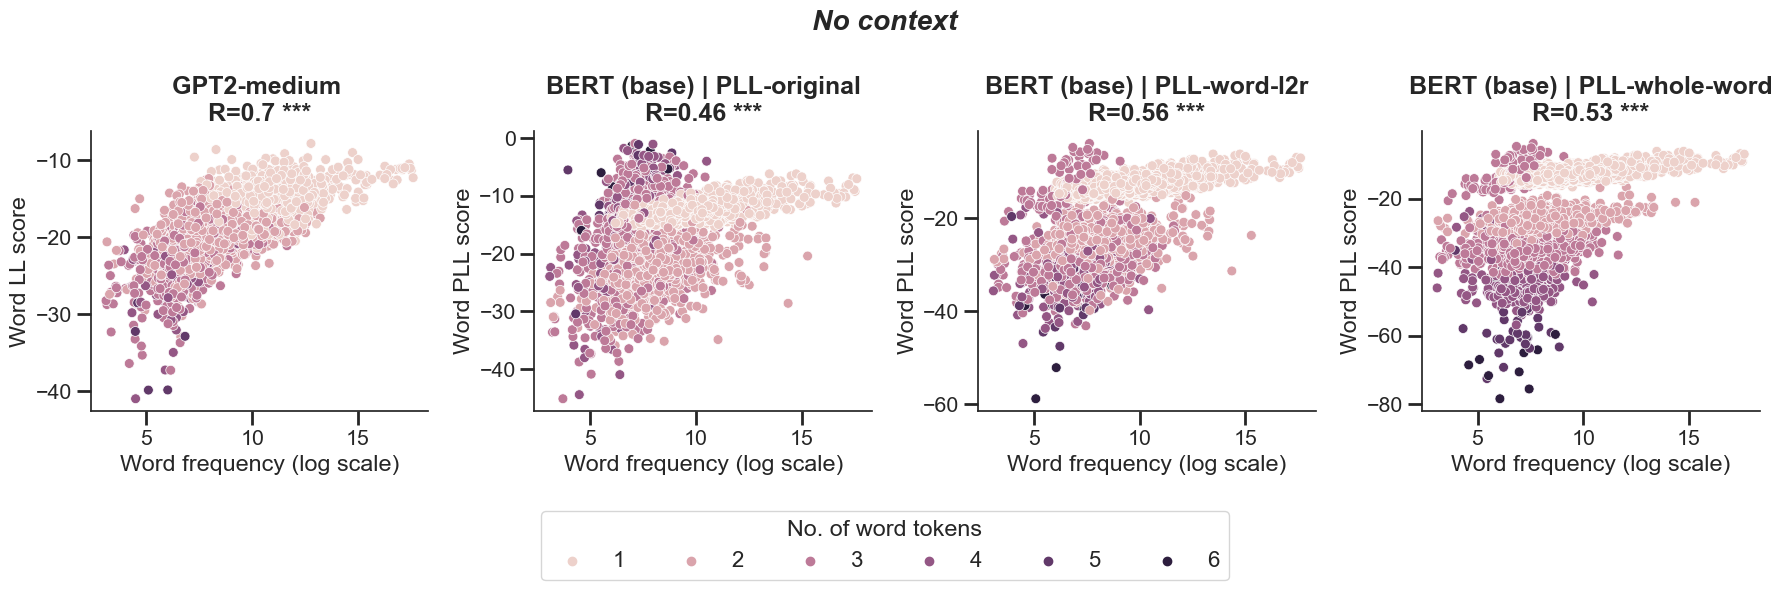

/var/folders/hd/jccv50v905774qvydg1s1gxc0000gn/T/ipykernel_20503/1172067780.py:35: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.scatterplot(data=plot_df, x="log freq", y="word score",


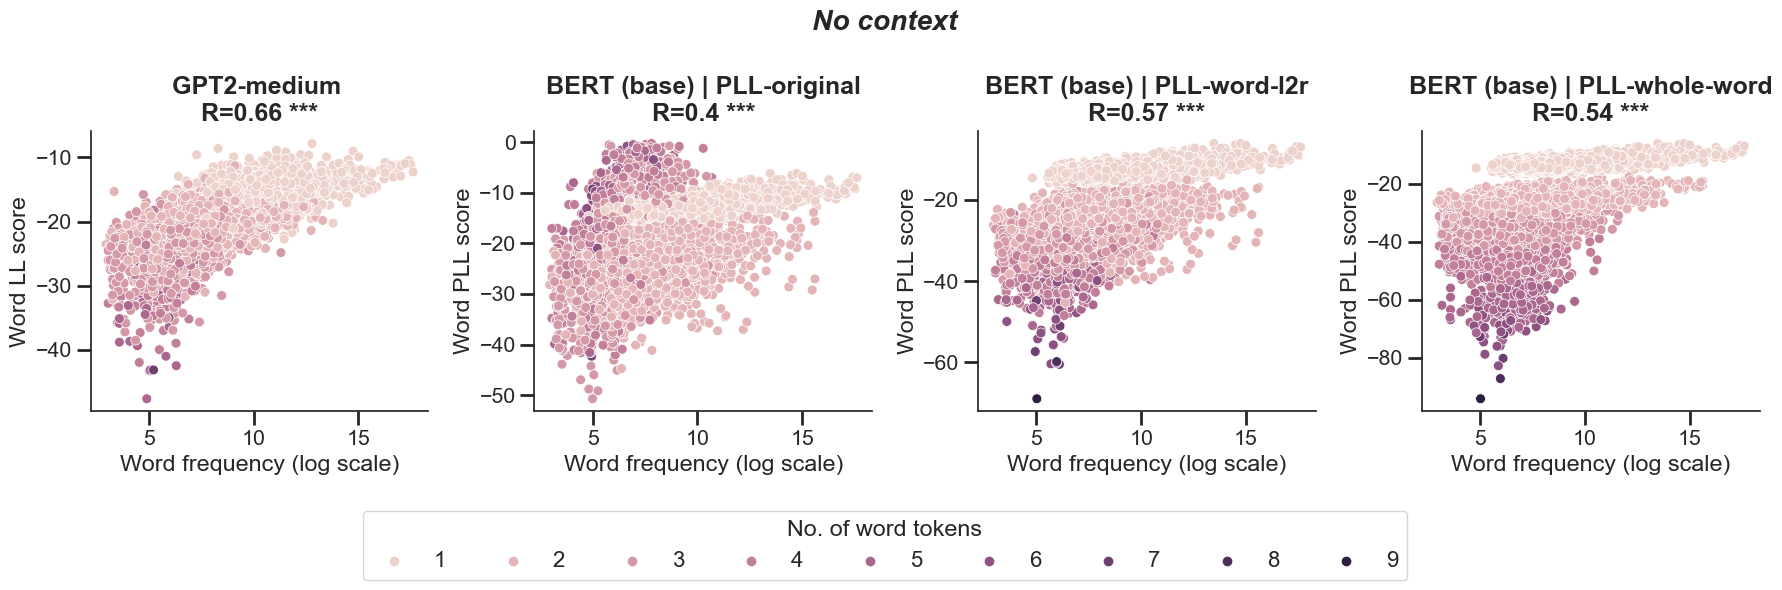

In [11]:
contexts = ["My word is", ""]

for context in contexts:
    for DATASET in ["LibriSpeech", "Brown"]:
        freq_vs_PLL_subplots(GPT_VERSION="gpt2-medium", BERT_VERSION="bert-base-cased", DATASET=DATASET,
                             context=context)